In [1]:
%matplotlib inline

seed_value = 100
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

# Data uploading

In [2]:
AIRPORT_ICAO = "ESGG"
#AIRPORT_ICAO = "ESSA"

#runway = "21"
#cluster = 2

DATA_DIR = os.path.join("..", "..")
DATA_DIR = os.path.join(DATA_DIR, "data")
DATA_DIR = os.path.join(DATA_DIR, "Regression")

# AIF
filename = AIRPORT_ICAO + "_metrics_AIF_horizontal_PIs_by_hour.csv"
#filename = AIRPORT_ICAO + "_metrics_AIF_horizontal_PIs_by_hour_rwy" + runway + "_cluster" + str(cluster) +".csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_AIF_horizontal_PIs_by_hour_df = pd.read_csv(full_filename, sep=' ')

# WIF
filename = AIRPORT_ICAO + "_metrics_WIF_horizontal_PIs_by_hour.csv"
#filename = AIRPORT_ICAO + "_metrics_WIF_horizontal_PIs_by_hour_rwy" + runway + "_cluster" + str(cluster) +".csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_WIF_horizontal_PIs_by_hour_df = pd.read_csv(full_filename, sep=' ')

# TIF
filename = AIRPORT_ICAO + "_metrics_TIF_horizontal_PIs_by_hour.csv"
#filename = AIRPORT_ICAO + "_metrics_TIF_horizontal_PIs_by_hour_rwy" + runway + "_cluster" + str(cluster) +".csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_TIF_horizontal_PIs_by_hour_df = pd.read_csv(full_filename, sep=' ')

# Average Additional Distance

## Medians of Average Additional Distance in TMA vs TIF

3745
1230
1071
735
511
366
61
25
12
7
                            OLS Regression Results                            
Dep. Variable:      addDistanceMedian   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     46.99
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           0.000130
Time:                        22:22:24   Log-Likelihood:                -22.996
No. Observations:                  10   AIC:                             49.99
Df Residuals:                       8   BIC:                             50.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

C:\Users\anale19\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


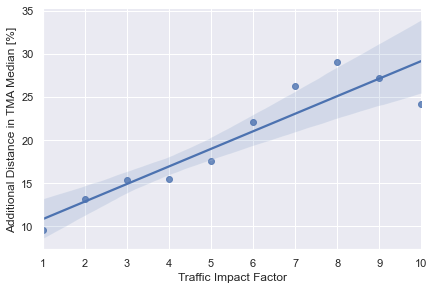

In [3]:
df = metrics_TIF_horizontal_PIs_by_hour_df.copy()
#df = df[df['numberOfFlights']>0]
p1 = df["distanceChangePercentMean"].quantile(0.05)
p2 = df["distanceChangePercentMean"].quantile(0.95)
df = df.loc[(df['distanceChangePercentMean'] > p1) & (df['distanceChangePercentMean'] < p2) ]

df.set_index(['TIF'], inplace=True)
df.sort_index(inplace=True)

median_df = pd.DataFrame(columns=['TIF', 'addDistanceMedian'])

for idx, group in df.groupby(level='TIF'):
    
    #idx_df = df.loc[idx]['additionalDistanceMedian']
    idx_df = group['distanceChangePercentMean']
    print(len(idx_df))
    
    idx_median = np.median(idx_df)
    median_df = median_df.append({'TIF': idx, 'addDistanceMedian': idx_median}, ignore_index=True)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='TIF',y='addDistanceMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Traffic Impact Factor')
#plt.ylabel('Additional Distance in TMA Median [NM]')
plt.ylabel('Additional Distance in TMA Median [%]')

#statsmodel:
X_df = median_df[['TIF']]
y_df = median_df[['addDistanceMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary())
# with outliers - ESGG: 0.84, ESSA: 0.93
# without outliers - ESGG: 0.86, ESSA: 0.93

## Medians of Average Additional Distance in TMA vs WIF

WIF
10.0    11.536667
10.0   -10.410000
10.0   -17.790000
10.0    32.346667
10.0    14.875000
10.0    62.070000
Name: distanceChangePercentMean, dtype: float64
                            OLS Regression Results                            
Dep. Variable:      addDistanceMedian   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1.745
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.223
Time:                        22:22:24   Log-Likelihood:                -28.011
No. Observations:                  10   AIC:                             60.02
Df Residuals:                       8   BIC:                             60.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

C:\Users\anale19\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


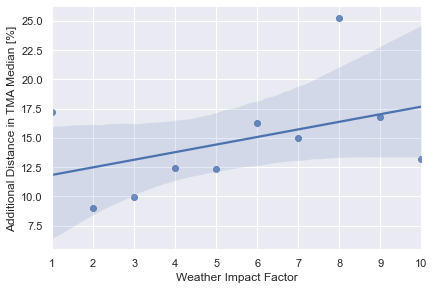

In [4]:
df = metrics_WIF_horizontal_PIs_by_hour_df.copy()
df.dropna(inplace=True)
df = df[df['numberOfFlights']>0]
p1 = df["distanceChangePercentMean"].quantile(0.05)
p2 = df["distanceChangePercentMean"].quantile(0.95)
df = df.loc[(df['distanceChangePercentMean'] > p1) & (df['distanceChangePercentMean'] < p2) ]

df.set_index(['WIF'], inplace=True)
df.sort_index(inplace=True)

median_df = pd.DataFrame(columns=['WIF', 'addDistanceMedian'])

for idx, group in df.groupby(level='WIF'):
    
    #idx_df = df.loc[idx]['additionalDistanceMean']
    idx_df = group['distanceChangePercentMean']
    if idx == 10:
        print(idx_df)

    idx_median = np.median(idx_df)
            
    median_df = median_df.append({'WIF': idx, 'addDistanceMedian': idx_median}, ignore_index=True)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='WIF',y='addDistanceMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Weather Impact Factor')
#plt.ylabel('Additional Distance in TMA Median [NM]')
plt.ylabel('Additional Distance in TMA Median [%]')

#statsmodel:
#median_df = median_df[median_df['WIF']<10]
X_df = median_df[['WIF']]
y_df = median_df[['addDistanceMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary()) 
# with outliers - ESGG: 0.49 ESSA: 0.61
# without outliers - ESGG: 0.18 ESSA: 0.18

## Medians of Average Additional Distance in TMA vs AIF

                            OLS Regression Results                            
Dep. Variable:      addDistanceMedian   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     816.2
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.44e-09
Time:                        22:22:24   Log-Likelihood:                -10.290
No. Observations:                  10   AIC:                             24.58
Df Residuals:                       8   BIC:                             25.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6476      0.517     10.921      0.0

C:\Users\anale19\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


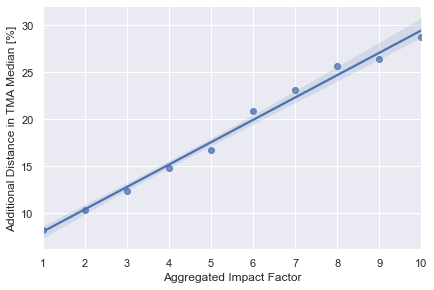

In [5]:
df = metrics_AIF_horizontal_PIs_by_hour_df.copy()
df.dropna(inplace=True)
#df = df[df['numberOfFlights']>0]
p1 = df["distanceChangePercentMean"].quantile(0.05)
p2 = df["distanceChangePercentMean"].quantile(0.95)
df = df.loc[(df['distanceChangePercentMean'] > p1) & (df['distanceChangePercentMean'] < p2) ]

df.set_index(['AIF'], inplace=True)
df.sort_index(inplace=True)


median_df = pd.DataFrame(columns=['AIF', 'addDistanceMedian'])

for idx, group in df.groupby(level='AIF'):
    
    #idx_df = df.loc[idx]['additionalDistanceMean']
    idx_df = group['distanceChangePercentMean']

    idx_median = np.median(idx_df)
            
    median_df = median_df.append({'AIF': idx, 'addDistanceMedian': idx_median}, ignore_index=True)

sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='AIF',y='addDistanceMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Aggregated Impact Factor')
#plt.ylabel('Additional Distance in TMA Median [NM]')
plt.ylabel('Additional Distance in TMA Median [%]')

#statsmodel:
X_df = median_df[['AIF']]
y_df = median_df[['addDistanceMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary()) 
# with outliers - ESGG: 0.81 ESSA: 0.76
# without outliers - ESGG: 0.67 ESSA: 0.79